## Zillow scenario:
#### We want to be able to predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env
import explore

from sklearn.model_selection import train_test_split

import sklearn.preprocessing

In [2]:
df = explore.get_zillow()

In [3]:
df.head()

,parcelid,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
0,11393337,1534.0,3.0,3.0,43439.0
1,11289917,1458.0,3.0,2.0,136104.0
2,11705026,1421.0,2.0,1.0,35606.0
3,14269464,2541.0,4.0,3.0,880456.0
4,11389003,1650.0,3.0,2.0,614000.0


In [4]:
# rename columns nicely
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [5]:
# set `parcelid` to index
df = df.set_index("parcelid")

In [6]:
df.head()

,square_feet,bedrooms,bathrooms,tax_value
parcelid,,,,
11393337,1534.0,3.0,3.0,43439.0
11289917,1458.0,3.0,2.0,136104.0
11705026,1421.0,2.0,1.0,35606.0
14269464,2541.0,4.0,3.0,880456.0
11389003,1650.0,3.0,2.0,614000.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21943 entries, 11393337 to 12942897
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   square_feet  21882 non-null  float64
 1   bedrooms     21937 non-null  float64
 2   bathrooms    21937 non-null  float64
 3   tax_value    21937 non-null  float64
dtypes: float64(4)
memory usage: 857.1 KB


In [8]:
# check for blanks/nulls
df.isnull().value_counts()

square_feet  bedrooms  bathrooms  tax_value
False        False     False      False        21882
True         False     False      False           55
             True      True       True             6
dtype: int64

In [9]:
df.isna().value_counts()

square_feet  bedrooms  bathrooms  tax_value
False        False     False      False        21882
True         False     False      False           55
             True      True       True             6
dtype: int64

In [10]:
df.isnull().sum()

square_feet    61
bedrooms        6
bathrooms       6
tax_value       6
dtype: int64

In [11]:
# get rid of nulls
df = df.dropna()

In [12]:
# check for blanks/nulls
df.isnull().value_counts()

square_feet  bedrooms  bathrooms  tax_value
False        False     False      False        21882
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21882 entries, 11393337 to 12942897
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   square_feet  21882 non-null  float64
 1   bedrooms     21882 non-null  float64
 2   bathrooms    21882 non-null  float64
 3   tax_value    21882 non-null  float64
dtypes: float64(4)
memory usage: 854.8 KB


# 1. Write a function named `plot_variable_pairs` that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

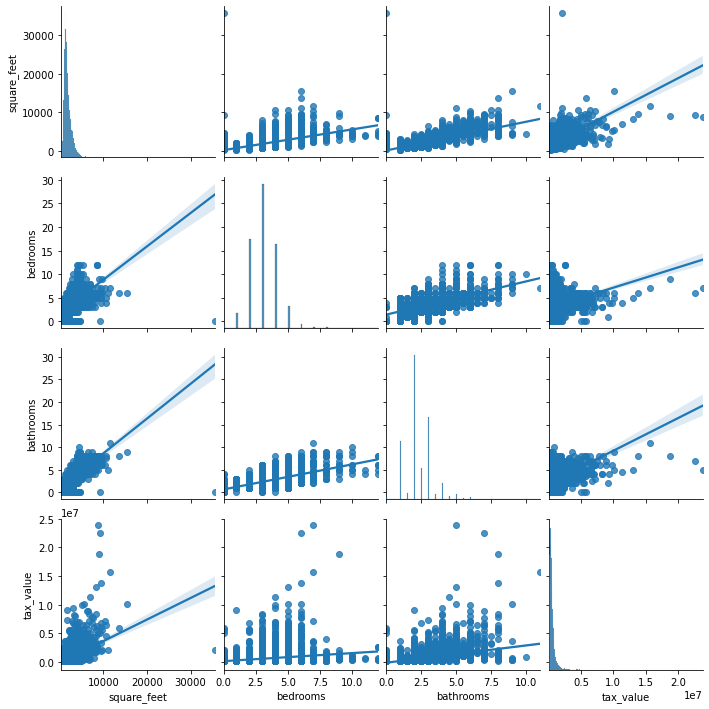

In [14]:
sns.pairplot(df, kind= "reg")

In [19]:
df.bedrooms.max()

12.0

In [20]:
df.bedrooms.describe()

count    21882.000000
mean         3.073302
std          1.116545
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedrooms, dtype: float64

In [21]:
df.bathrooms.describe()

count    21882.000000
mean         2.325679
std          0.990098
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: bathrooms, dtype: float64

In [22]:
df.tax_value.describe()

count    2.188200e+04
mean     5.019008e+05
std      6.411898e+05
min      1.050400e+04
25%      2.127882e+05
50%      3.680140e+05
75%      5.884635e+05
max      2.385837e+07
Name: tax_value, dtype: float64

In [23]:
df.square_feet.describe()

count    21882.000000
mean      1808.426926
std        973.442464
min        242.000000
25%       1194.000000
50%       1562.000000
75%       2145.000000
max      35640.000000
Name: square_feet, dtype: float64

### visualize outliers:

<AxesSubplot:xlabel='tax_value'>

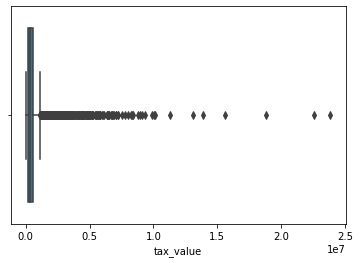

In [24]:
sns.boxplot(x="tax_value", data=df)
# seven major outliers skewing the data

<AxesSubplot:xlabel='square_feet'>

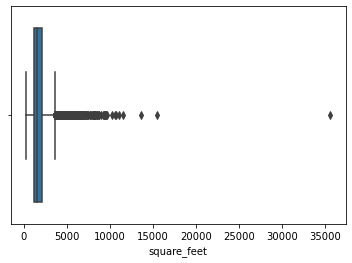

In [25]:
sns.boxplot(x="square_feet", data=df)
# three MAJOR outliers

In [26]:
# Let's use IQR for the entire dataset
tvq1 = df.tax_value.quantile(.25)
tvq3 = df.tax_value.quantile(.75)
tvq1, tvq3

(212788.25, 588463.5)

In [28]:
tviqr = tvq3 - tvq1
tviqr

375675.25

In [29]:
# apply Tukey's multiplier
multiplier = 1.5
upper_bound = tvq3 + (multiplier * tviqr)
lower_bound = tvq1 - (multiplier * tviqr)

In [30]:
upper_bound, lower_bound
# having a negative lower bound means: we don't have outliers on the lower end
# upper bound is stating that tax_values > 1.15million are outliers

(1151976.375, -350724.625)

In [31]:
# let's remove them upper outliers.
df = df[df.tax_value < upper_bound]
df.shape

(20450, 4)

<AxesSubplot:xlabel='tax_value'>

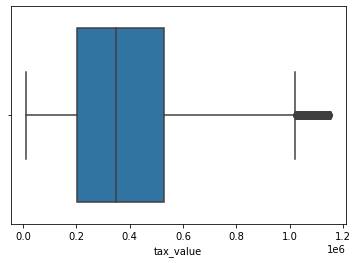

In [32]:
sns.boxplot(x="tax_value", data=df)

<AxesSubplot:xlabel='square_feet'>

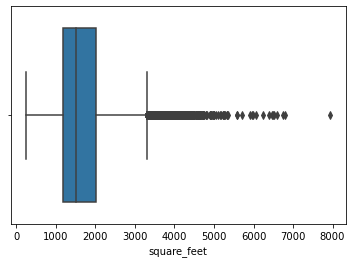

In [33]:
sns.boxplot(x="square_feet", data=df)

Original DF:

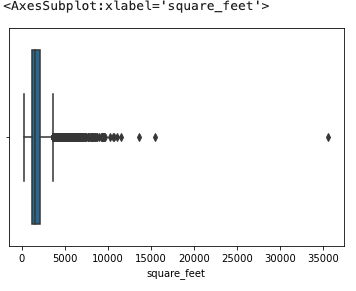

There still appears to be an outlier, although, the data is more visible than before.

In [34]:
# Let's use IQR for the entire dataset
sftq1 = df.square_feet.quantile(.25)
sftq3 = df.square_feet.quantile(.75)
sftq1, sftq3

(1171.0, 2023.0)

In [35]:
sftiqr = sftq3 - sftq1
sftiqr

852.0

In [37]:
# apply Tukey's multiplier
multiplier = 1.5
upper_bound = sftq3 + (multiplier * sftiqr)
lower_bound = sftq1 - (multiplier * sftiqr)

In [38]:
upper_bound, lower_bound
#negative lower bound means no lower outliers
# anything over 3_301 sqft would be an outlier

(3301.0, -107.0)

In [39]:
# let's remove them upper outliers.
df1 = df[df.square_feet < upper_bound]
df1.shape

(19696, 4)

In [ ]:
sns.boxplot(x="square_feet", data=df)

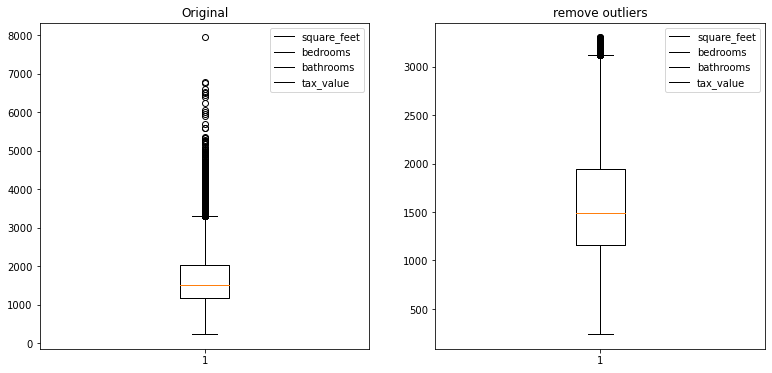

In [41]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.boxplot(df.square_feet)
plt.title('Original')
plt.legend(df)

plt.subplot(122)
plt.boxplot(df1.square_feet)
plt.title('remove outliers')
plt.legend(df1);

<AxesSubplot:xlabel='tax_value'>

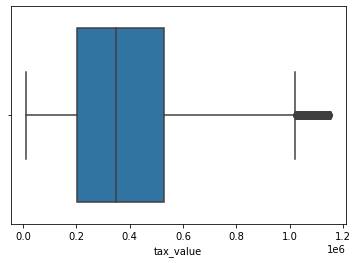

In [44]:
sns.boxplot(x="tax_value", data=df)

<AxesSubplot:xlabel='tax_value'>

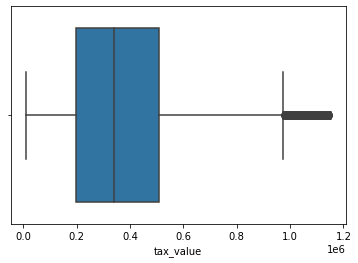

In [43]:
sns.boxplot(x="tax_value", data=df1)

In [45]:
# df1 has both tax_values & sqft outliers removed
# 754 less properities than df: 19696 properties
df1.tax_value.describe()

count    1.969600e+04
mean     3.765382e+05
std      2.356043e+05
min      1.050400e+04
25%      1.968768e+05
50%      3.390930e+05
75%      5.076250e+05
max      1.150745e+06
Name: tax_value, dtype: float64

In [46]:
# df has tax_values outliers removed
# 20450 properties
df.tax_value.describe()

count    2.045000e+04
mean     3.890907e+05
std      2.457934e+05
min      1.050400e+04
25%      2.017352e+05
50%      3.471120e+05
75%      5.290000e+05
max      1.151798e+06
Name: tax_value, dtype: float64

I think I'll work with `df1` data.
I think the removal of both types of outliers will give a better picture of what 'average' CA'ians would purchase.

### Test out clean_zillow function

In [2]:
df = explore.get_zillow()

In [3]:
df.head(3)

,parcelid,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
0,11393337,1534.0,3.0,3.0,43439.0
1,11289917,1458.0,3.0,2.0,136104.0
2,11705026,1421.0,2.0,1.0,35606.0


In [4]:
df = explore.clean_zillow(df)

In [5]:
df.head(3)

,square_feet,bedrooms,bathrooms,tax_value
parcelid,,,,
11393337,1534.0,3.0,3.0,43439.0
11289917,1458.0,3.0,2.0,136104.0
11705026,1421.0,2.0,1.0,35606.0


In [6]:
df.shape

(19696, 4)

In [8]:
df.isnull().sum()

square_feet    0
bedrooms       0
bathrooms      0
tax_value      0
dtype: int64

### Test `wrangle_zillow()`

In [2]:
train, validate, test = explore.wrangle_zillow()

In [3]:
train, validate, test

(          square_feet  bedrooms  bathrooms  tax_value
 parcelid                                             
 12652575       1938.0       3.0        3.0   608322.0
 14596739        608.0       1.0        1.0   173649.0
 14687559       2344.0       3.0        2.5   456079.0
 14109406       3023.0       4.0        2.5   119834.0
 13999346       1479.0       4.0        1.5    63565.0
 ...               ...       ...        ...        ...
 12428203       2028.0       5.0        4.0   307644.0
 13955467       2019.0       3.0        2.0   519151.0
 12338709       1605.0       3.0        2.0   293620.0
 12777972       2174.0       4.0        3.0   672104.0
 12113493        864.0       1.0        1.0   117093.0
 
 [11029 rows x 4 columns],
           square_feet  bedrooms  bathrooms  tax_value
 parcelid                                             
 14187623       1449.0       3.0        2.5   575000.0
 14606960       2294.0       3.0        2.5   643584.0
 13871777       2381.0       4.0    

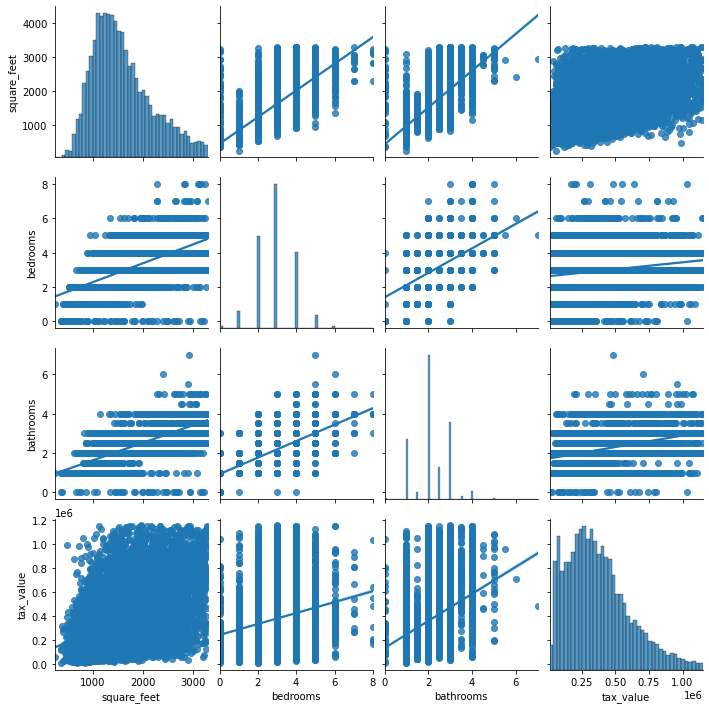

In [3]:
sns.pairplot(train, kind= "reg")

### Test `plot_variable_pairs()`
- ends up producing **VERY** similar visuals as: `sns.pairplot(train, kind= "reg")`

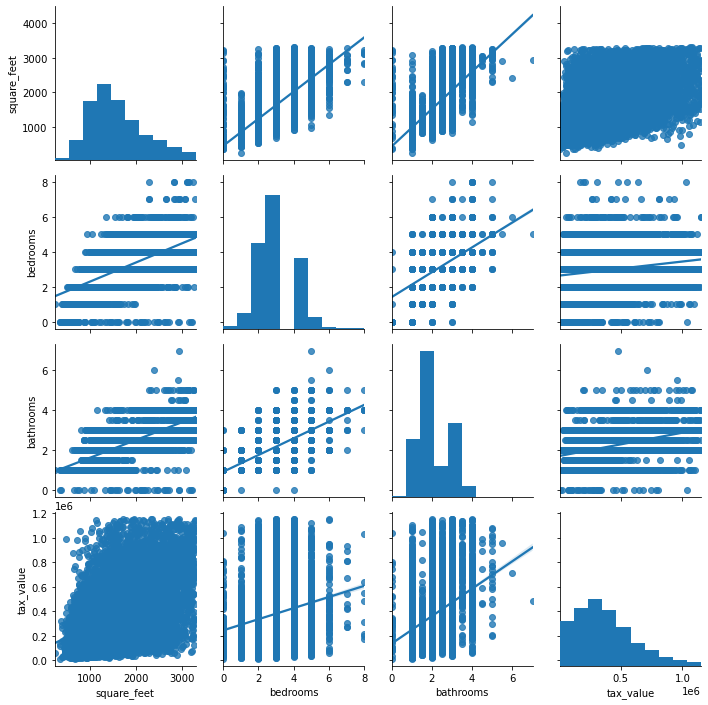

In [4]:
explore.plot_variable_pairs(train)

# 2. Write a function named `fips_to_county` that accepts your telco churn dataframe and returns a dataframe with a new feature `county`.

In [17]:
fips = pd.read_csv("fips.csv", delimiter = "\t")

In [18]:
fips.head()

,FIPS,Name,State
0,6001,Alameda,CA
1,6003,Alpine,CA
2,6005,Amador,CA
3,6007,Butte,CA
4,6009,Calaveras,CA


# 3. Write a function named `plot_categorical_and_continuous_vars` that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [8]:
train.describe()

,square_feet,bedrooms,bathrooms,tax_value
count,11029.000000,11029.000000,11029.000000,1.102900e+04
mean,1596.463143,2.933992,2.153278,3.766897e+05
std,591.317075,0.989423,0.758319,2.343663e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1158.000000,2.000000,2.000000,2.012210e+05
50%,1484.000000,3.000000,2.000000,3.376860e+05
75%,1936.000000,4.000000,3.000000,5.050000e+05
max,3299.000000,8.000000,7.000000,1.150745e+06


In [9]:
train.head(3)

,square_feet,bedrooms,bathrooms,tax_value
parcelid,,,,
12652575,1938.0,3.0,3.0,608322.0
14596739,608.0,1.0,1.0,173649.0
14687559,2344.0,3.0,2.5,456079.0


In [ ]:
quant_vars = ['square_feet', 'bathrooms', 'tax_value']
cat_vars = ['bedrooms']

(0.0, 4.0)

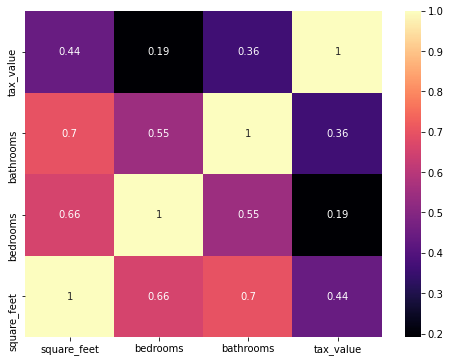

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='magma', annot=True)
plt.ylim(0, 4)

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


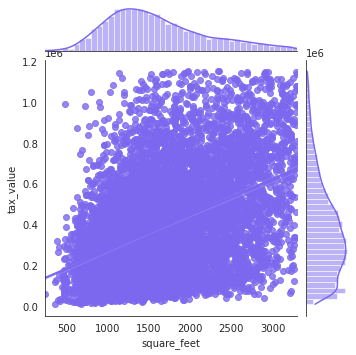

In [16]:
with sns.axes_style('white'):
    j = sns.jointplot("square_feet", "tax_value", data=train, kind='reg', height=5, color= 'mediumslateblue');
plt.show()

David's viz

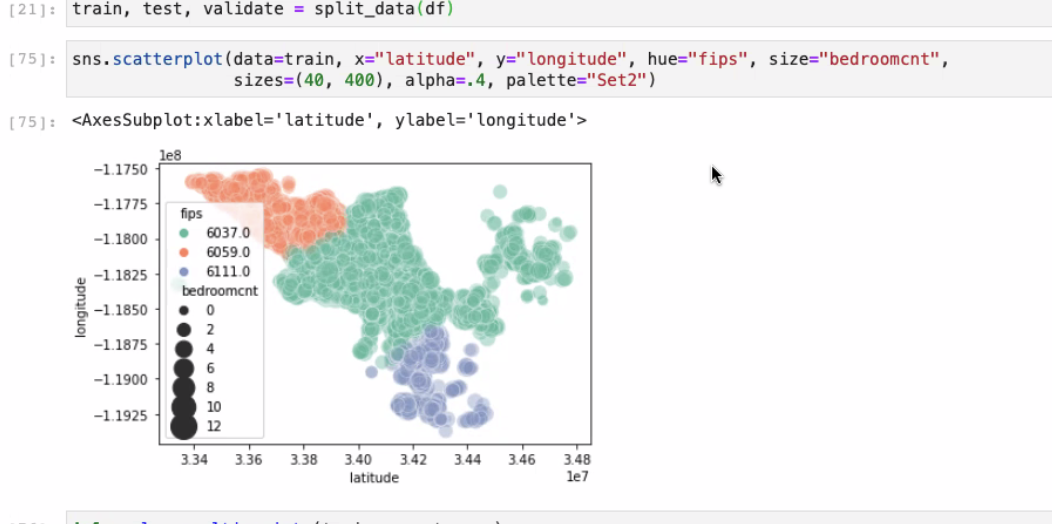

Gabby's viz

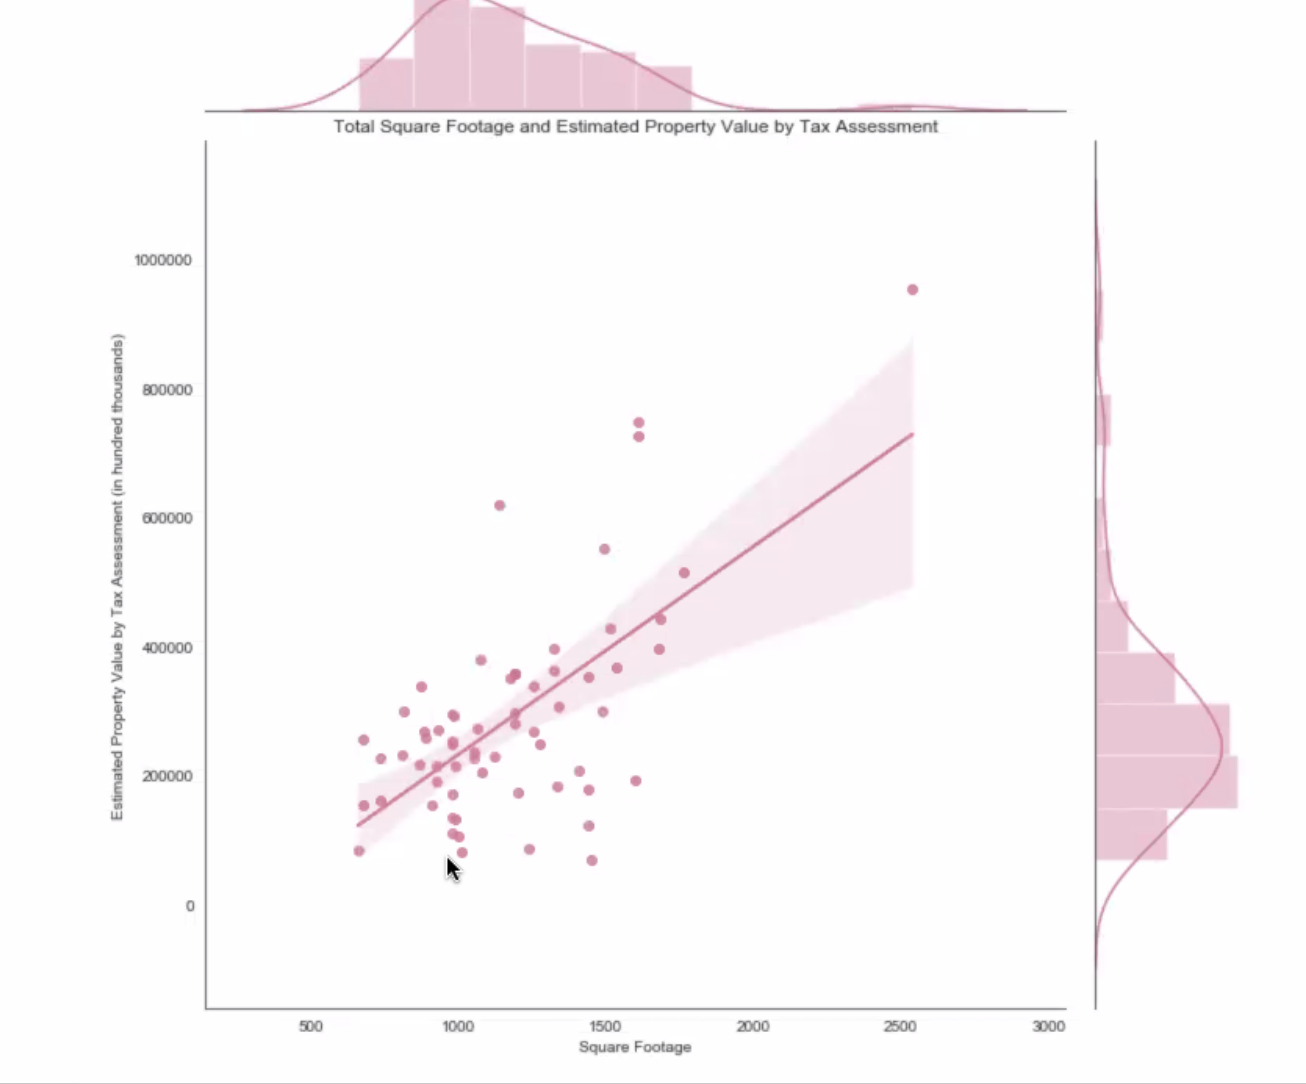

### 4. Save the functions you have written to create visualizations in a file named `explore.py`. Rewrite your notebook code so that you are using the functions imported from this file.

### 5. Explore your dataset with any other visualizations you think will be helpful.

### 6. In a seperate notebook, use the functions you have developed in this exercise with the mall customers dataset.